##Objective: WAP to train and evaluate a Recurrent Neural Network using PyTorch Library to predict the next value in a sample time series dataset.

###Description:
This project implements a Recurrent Neural Network (RNN) using PyTorch to perform time series forecasting on the Bike Sharing Dataset (Washington D.C.). The model predicts the number of bikes rented at a given hour based on past data patterns.

###Key features of the code:

- Data Preprocessing:
The dataset is normalized using MinMaxScaler, and sequences are created based on a defined seq_length.

- Hyperparameter Tuning:
A manual grid search is performed over several combinations of:

 -- Sequence length (seq_length)

 -- Hidden size of RNN layers

 -- Number of RNN layers

 -- Learning rate:
The best combination is selected based on validation loss.

- Model Training:
A final RNN is trained using the best parameters found during tuning.

- Visualizations:

 -- Multiple plots help analyze performance:

 -- Training loss over epochs

 -- Actual vs predicted bike rentals (full and zoomed)

 -- Residual error plot


###My Comments:
1. Switch to LSTM or GRU may improve performance
2. Maybe increasing model complexity can provide better results.


🔍 Starting Hyperparameter Tuning...

Params - seq_len:12, hidden:32, layers:1, lr:0.001 | Val Loss: 0.0482
Params - seq_len:12, hidden:32, layers:1, lr:0.0005 | Val Loss: 0.0504
Params - seq_len:12, hidden:32, layers:2, lr:0.001 | Val Loss: 0.0395
Params - seq_len:12, hidden:32, layers:2, lr:0.0005 | Val Loss: 0.0474
Params - seq_len:12, hidden:64, layers:1, lr:0.001 | Val Loss: 0.0455
Params - seq_len:12, hidden:64, layers:1, lr:0.0005 | Val Loss: 0.0471
Params - seq_len:12, hidden:64, layers:2, lr:0.001 | Val Loss: 0.0575
Params - seq_len:12, hidden:64, layers:2, lr:0.0005 | Val Loss: 0.0521
Params - seq_len:24, hidden:32, layers:1, lr:0.001 | Val Loss: 0.0461
Params - seq_len:24, hidden:32, layers:1, lr:0.0005 | Val Loss: 0.0764
Params - seq_len:24, hidden:32, layers:2, lr:0.001 | Val Loss: 0.0506
Params - seq_len:24, hidden:32, layers:2, lr:0.0005 | Val Loss: 0.0461
Params - seq_len:24, hidden:64, layers:1, lr:0.001 | Val Loss: 0.0474
Params - seq_len:24, hidden:64, layers:1, lr:0.

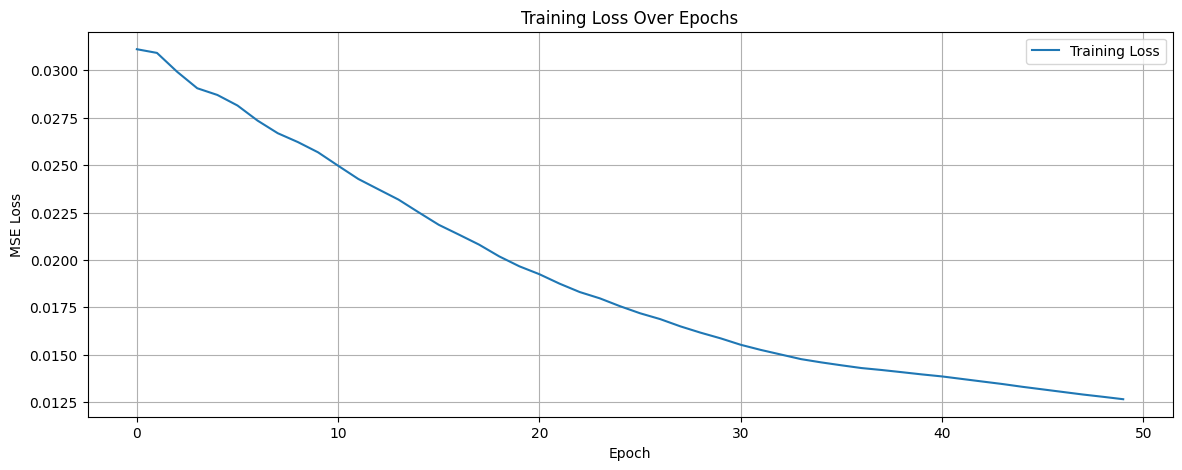

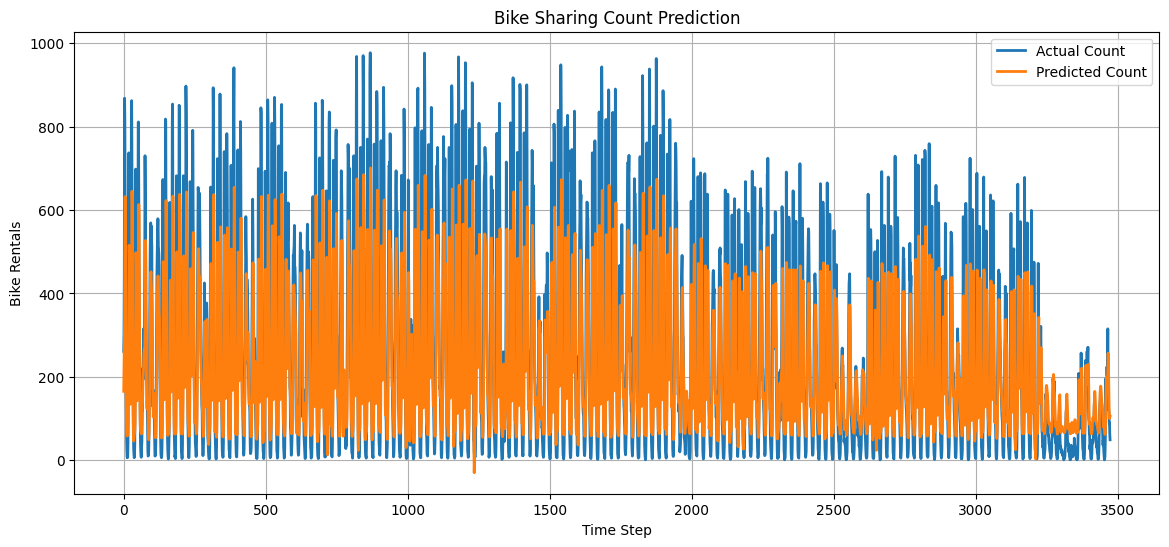

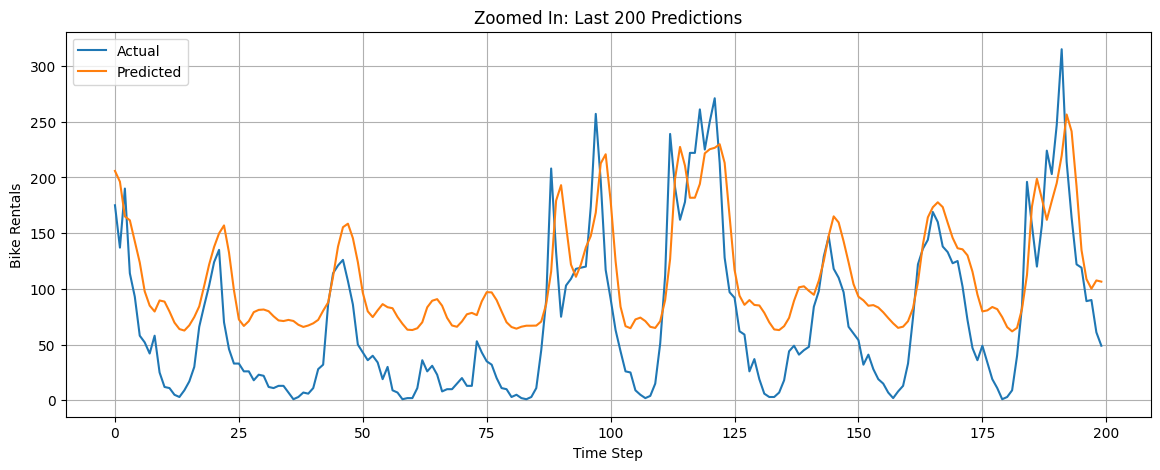

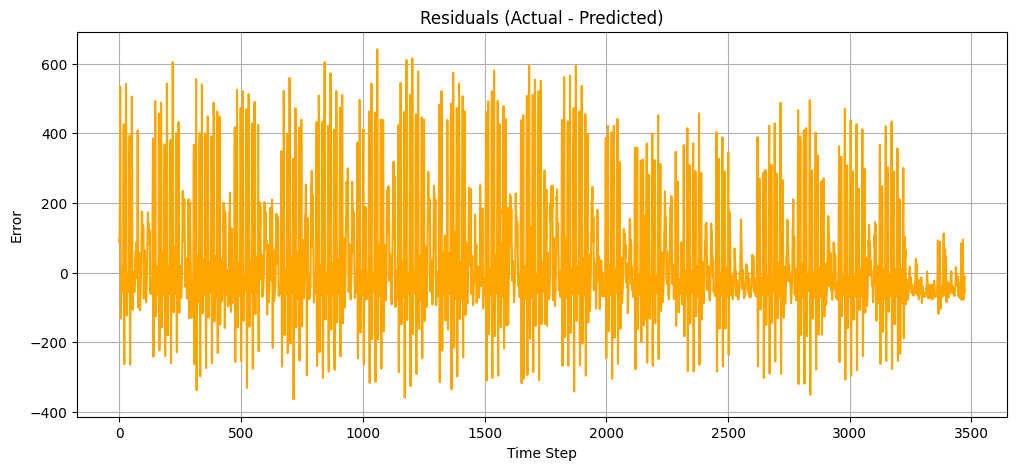

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Download data locally
df = pd.read_csv('hour.csv', parse_dates=["dteday"])
data = df[['cnt']].values.astype(float)

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# -------------------------------
# Step 2: RNN Model Definition
# -------------------------------
class RNNPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(RNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# -------------------------------
# Step 3: Hyperparameter Tuning
# -------------------------------
param_grid = {
    'seq_length': [12, 24],
    'hidden_size': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}

best_loss = float('inf')
best_params = {}

print("🔍 Starting Hyperparameter Tuning...\n")

for seq_length in param_grid['seq_length']:
    X, y = create_sequences(data_normalized, seq_length)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).float()

    for hidden_size in param_grid['hidden_size']:
        for num_layers in param_grid['num_layers']:
            for lr in param_grid['learning_rate']:
                model = RNNPredictor(hidden_size=hidden_size, num_layers=num_layers)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                for epoch in range(15):  # shorter epochs for tuning
                    model.train()
                    output = model(X_train_tensor)
                    loss = criterion(output, y_train_tensor)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                model.eval()
                val_pred = model(X_val_tensor)
                val_loss = criterion(val_pred, y_val_tensor).item()

                print(f"Params - seq_len:{seq_length}, hidden:{hidden_size}, layers:{num_layers}, lr:{lr} | Val Loss: {val_loss:.4f}")

                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = {
                        'seq_length': seq_length,
                        'hidden_size': hidden_size,
                        'num_layers': num_layers,
                        'learning_rate': lr
                    }

print("\n✅ Best Hyperparameters Found:", best_params)

# -------------------------------
# Step 4: Train Final Model
# -------------------------------
X, y = create_sequences(data_normalized, best_params['seq_length'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

model = RNNPredictor(
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers']
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

train_losses = []

print("\n🚀 Training Final Model...\n")
for epoch in range(50):
    model.train()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

# -------------------------------
# Step 5: Evaluation
# -------------------------------
model.eval()
predictions = model(X_test_tensor).detach().numpy()
y_test_np = y_test_tensor.numpy()

# Inverse transform
predicted_counts = scaler.inverse_transform(predictions)
actual_counts = scaler.inverse_transform(y_test_np)
residuals = actual_counts - predicted_counts

# -------------------------------
# Step 6: Visualizations
# -------------------------------
plt.figure(figsize=(14, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot predicted vs actual
plt.figure(figsize=(14, 6))
plt.plot(actual_counts, label='Actual Count', linewidth=2)
plt.plot(predicted_counts, label='Predicted Count', linewidth=2)
plt.title('Bike Sharing Count Prediction')
plt.xlabel('Time Step')
plt.ylabel('Bike Rentals')
plt.legend()
plt.grid(True)
plt.show()

# Zoomed-in last 200 samples
plt.figure(figsize=(14, 5))
plt.plot(actual_counts[-200:], label='Actual')
plt.plot(predicted_counts[-200:], label='Predicted')
plt.title("Zoomed In: Last 200 Predictions")
plt.xlabel("Time Step")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
plt.figure(figsize=(12, 5))
plt.plot(residuals, color='orange')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.grid(True)
plt.show()
